In [0]:
###Workflow

# Extract Frames
# Move to "asset1" and "asset2" folders
# Create a test folder
# Move 5 images each from asset1 and asset2
# train an image recognition model to distinguish images between the two folders
# Apply the model on the ten images stored in “test” folder

In [0]:
# Importing libraries

import pandas as pd
import numpy as np
import cv2
import os
import random

import matplotlib.pyplot as plt

from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.utils import shuffle

import shutil


In [3]:
import time

#Keras, deep learning libraries
from keras.models import Sequential, load_model
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras import backend as K
import tensorflow as tf
from tensorflow.python.client import device_lib

Using TensorFlow backend.


#### Note : I have tried to create functions for as many tasks as I can for better scalability and readability. 

# Data Extraction
- Extracting Frames
- Creating test data


## Extracting Frames from Videos

In [0]:
# Extracting frams

def extractFrames(pathIn, pathOut):      #input and output paths
  '''Function to extract and save frames from a video, to a specified folder'''
  if not os.path.exists(pathOut):    
    os.mkdir(pathOut)
    
  cap = cv2.VideoCapture(pathIn)
  count = 0
  while (cap.isOpened()):
    
    # Capture frame-by-frame
    ret, frame = cap.read()

    if ret == True:
      
      cv2.imwrite(os.path.join(pathOut, "frame{:d}.jpg".format(count)), frame)
      count += 1
    else:
      break

  # When everything done, release the capture
  cap.release()
  cv2.destroyAllWindows()


In [0]:
extractFrames('VID-20190506-WA0017.mp4','asset1')
extractFrames('VID-20190506-WA0019.mp4','asset2')

## Creating test folder

In [0]:
if not os.path.exists('test'):
  os.mkdir('test')

In [8]:
# frames 0 to 4 are asset1 and 5 to 9 are asset2

shutil.move("asset1/frame0.jpg", "test/frame0.jpg")
shutil.move("asset1/frame1.jpg", "test/frame1.jpg")
shutil.move("asset1/frame2.jpg", "test/frame2.jpg")
shutil.move("asset1/frame3.jpg", "test/frame3.jpg")
shutil.move("asset1/frame4.jpg", "test/frame4.jpg")
shutil.move("asset2/frame5.jpg", "test/frame5.jpg")
shutil.move("asset2/frame6.jpg", "test/frame6.jpg")
shutil.move("asset2/frame7.jpg", "test/frame7.jpg")
shutil.move("asset2/frame8.jpg", "test/frame8.jpg")
shutil.move("asset2/frame9.jpg", "test/frame9.jpg")

'test/frame9.jpg'

## Loading data and preprocessing

#### Note : Preprocessing of the data includes resizing and normalization.

#### This makes the model computationally faster and more accurate. 

In [0]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 3

#### Following fucntion loads as well as resizes images from the mentioned folder.

In [0]:
# create dataframe and labels as asset1 and asset2

def load_images_from_folder(folder):
  '''loading and resizing of images from mentioned folders'''
  images = []
  for filename in os.listdir(folder):
      img = cv2.imread(os.path.join(folder,filename))
      img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
      if img is not None:
          images.append(img)
  return images

In [11]:
asset1_frames = load_images_from_folder('asset1')
asset2_frames = load_images_from_folder('asset2')
test_frames = load_images_from_folder('test')

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [12]:
print('Asset1 Frames')
print(type(asset1_frames))
print(np.shape(asset1_frames))
print('--------------')

print('Asset2 Frames')
print(type(asset2_frames))
print(np.shape(asset2_frames))
print('--------------')

print('Test Frames')
print(type(test_frames))
print(np.shape(test_frames))
print('--------------')

Asset1 Frames
<class 'list'>
(468, 128, 128, 3)
--------------
Asset2 Frames
<class 'list'>
(429, 128, 128, 3)
--------------
Test Frames
<class 'list'>
(10, 128, 128, 3)
--------------


#### We are converting the list of asset1 and asset2 images arrays, as CNN accepts input as an array of images.

In [0]:
asset1_frames = np.asarray(asset1_frames)
asset2_frames = np.asarray(asset2_frames)
test_frames = np.asarray(test_frames)

In [14]:
print('Asset1')
print(type(asset1_frames))
print(np.shape(asset1_frames))
print('--------------')
print('Asset2')
print(type(asset2_frames))
print(np.shape(asset2_frames))
print('--------------')
print('Test')
print(type(test_frames))
print(np.shape(test_frames))
print('--------------')

Asset1
<class 'numpy.ndarray'>
(468, 128, 128, 3)
--------------
Asset2
<class 'numpy.ndarray'>
(429, 128, 128, 3)
--------------
Test
<class 'numpy.ndarray'>
(10, 128, 128, 3)
--------------


### Joining asset1 and asset2 to create training data

In [0]:
frames = np.concatenate((asset1_frames, asset2_frames), axis = 0)

In [16]:
np.shape(frames)

(897, 128, 128, 3)

### Creating labels

In [0]:
# labels of asset1 frames
array1 = np.ones(shape = (np.shape(asset1_frames)[0],1), dtype=int)

In [0]:
# labels of asset2 frames
array2 = np.zeros(shape = (np.shape(asset2_frames)[0],1), dtype=int)

In [0]:
# training data labels
frames_lab = np.concatenate((array1, array2), axis = 0)

In [24]:
np.shape(frames_lab)

(897, 1)

In [25]:
frames_lab[:10]

array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

### Shuffling the training dataset

We need to shuffle the images and labels together, as they are all in sequential form which is not good for CNN. 

In [0]:
## Shuffle both features and labels
frames, frames_lab = shuffle(frames, frames_lab, random_state=0)

#### There are different types of nomalizations. A lot of times, mean value is subtracted from the batch, and the resulting value is divided by std deviation, which centers the mean at 0. 
#### But we are not doing this to avoid negative values. Instead, we will simply multiply the given value with the maximum, i.e., 255.

In [0]:
## Normalisation

frames = frames.astype('float32')/255
test_frames = test_frames.astype('float32')/255

## Building the model

## Convolution Neural Network

#### Convolution Layer :
- Convolution is the first layer to extract features from an input image. Convolution preserves the relationship between pixels by learning image features using small squares of input data.

- The output of the convolution operation between the filter and the input image is summed with a bias term and passed through a non-linear activation function. The purpose of the activation function is to introduce non-linearity into our network.


#### Max Pooling Layer : 
- In max pooling, a window passes over an image according to a set stride (how many units to move on each pass). At each step, the maximum value within the window is pooled into an output matrix, hence the name max pooling.

- This helps reduce overfitting and computational power required.


#### Flattening Layer : 
- Flattening involves transforming the entire pooled feature map matrix into a single long feature vector which is then fed to the neural network for processing.


#### Fully Connected Layer : 
- Neurons in a fully connected layer have full connections to all activations in the previous layer, as seen in regular Neural Networks.

- Fully connected layer looks at the output of the previous layer (which as we remember should represent the activation maps of high level features) and determines which features most correlate to a particular class.

In [0]:
#Initialize the model

model = Sequential()      

# Step 1 - Convolution
# 48 filters, (3x3) kernal size, 'same' value for padding, input shape 128x128 and 3 (RGB), activation fucntion is ReLU  
model.add(Conv2D(48, (3, 3), padding='same', input_shape=(128, 128, 3), activation = 'relu'))
 
# Step 2 - Pooling
# factors by which to downscale (vertical, horizontal)
model.add(MaxPooling2D(pool_size=(2, 2)))

# Step 3 - Flattening
# Flattens the input
model.add(Flatten())

# Step 4 - Full connection
# 512 nodes, relu activation
model.add(Dense(units = 512, activation = 'relu'))
# Sigmoid for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

## Model Summary

In [45]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 128, 128, 48)      1344      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 64, 64, 48)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 196608)            0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               100663808 
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 513       
Total params: 100,665,665
Trainable params: 100,665,665
Non-trainable params: 0
_________________________________________________________________


## Training the model

In [46]:
# Train the model

start = time.time()
model_info = model.fit(frames, frames_lab, 
                       batch_size=16, epochs=10, 
                       verbose=1)
end = time.time()
model.save("initial_model.h5")

Epoch 1/10
897/897 [==============================] - 7s 8ms/step - loss: 0.0127 - acc: 0.9922
Epoch 2/10
897/897 [==============================] - 5s 5ms/step - loss: 1.1002e-07 - acc: 1.0000
Epoch 3/10
897/897 [==============================] - 5s 5ms/step - loss: 1.1002e-07 - acc: 1.0000
Epoch 4/10
897/897 [==============================] - 5s 5ms/step - loss: 1.1002e-07 - acc: 1.0000
Epoch 5/10
897/897 [==============================] - 5s 5ms/step - loss: 1.1002e-07 - acc: 1.0000
Epoch 6/10
897/897 [==============================] - 5s 5ms/step - loss: 1.1002e-07 - acc: 1.0000
Epoch 7/10
897/897 [==============================] - 5s 5ms/step - loss: 1.1002e-07 - acc: 1.0000
Epoch 8/10
897/897 [==============================] - 5s 5ms/step - loss: 1.1002e-07 - acc: 1.0000
Epoch 9/10
897/897 [==============================] - 5s 5ms/step - loss: 1.1002e-07 - acc: 1.0000
Epoch 10/10
897/897 [==============================] - 5s 5ms/step - loss: 1.1002e-07 - acc: 1.0000


## Applying the model on the test data

In [0]:
result = model.predict(test_frames)

Class: [0.]


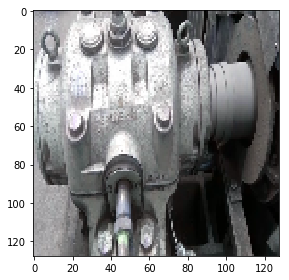

Class: [0.]


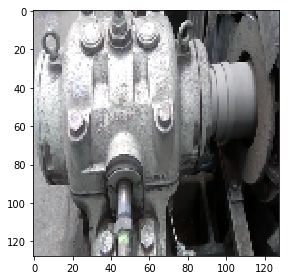

Class: [0.]


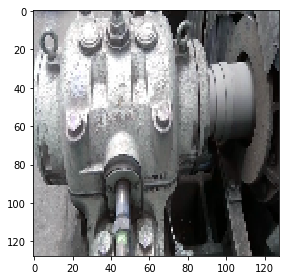

Class: [1.]


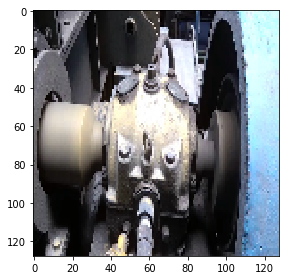

Class: [1.]


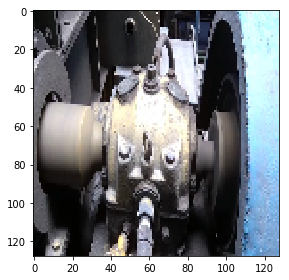

Class: [1.]


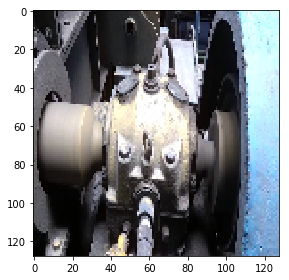

Class: [1.]


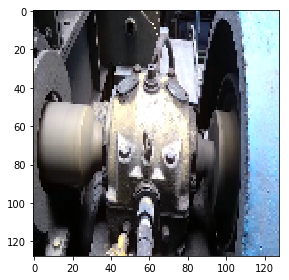

Class: [1.]


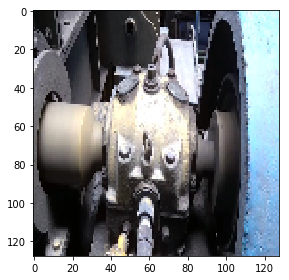

Class: [0.]


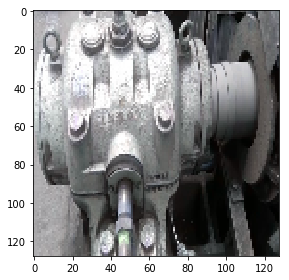

Class: [0.]


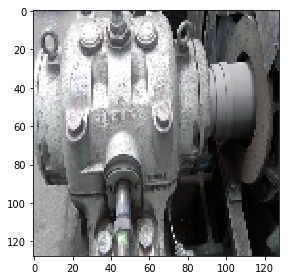

In [48]:
i=0
for i  in range(len(test_frames)):
  print("Class:",result[i])
  imshow(test_frames[i])
  plt.show()

In [49]:
result

array([[0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.]], dtype=float32)

## Future Improvements :
- Even a simple CNN model has given us best result (accuracy = 1) for the classification problem at hand. That's why I have not gone ahead to create any other more complex architecture.

- But, more complex architerctures such as VGG 16 can be implemented if an extra robust model was needed. This achitecture has total 16 layers.

- To avoid superfitting various measures such as dropout, data augmentation etc can be implemented.